<a href="https://colab.research.google.com/github/soumyagulla/commonsense/blob/master/Common_Sense_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import warnings
import scipy
import sklearn
import tqdm
import keras
import tensorflow as tf

In [0]:
from tqdm import tqdm
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras import optimizers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
import re
import warnings 
warnings.filterwarnings('ignore')

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'1bT0xOuIvL9sqwvsbVwhVhoij8u_evaWn'}) # replace the id with id of file you want to access
downloaded.GetContentFile('subtaskA_data_all.csv') 

In [0]:
#reading files 
try:
	data = pd.read_csv('subtaskA_data_all.csv')
	data.shape
except:
	print("input file is missing")

In [153]:
data.shape

(10000, 3)

In [154]:
data

,id,sent0,sent1
0,0,He poured orange juice on his cereal.,He poured milk on his cereal.
1,1,He drinks apple.,He drinks milk.
2,2,Jeff ran a mile today,"Jeff ran 100,000 miles today"
3,3,A mosquito stings me,I sting a mosquito
4,4,A niece is a person.,A giraffe is a person.
...,...,...,...
9995,9995,Mark ate a big bitter cherry pie,Mark ate a big sweet cherry pie
9996,9996,Gloria wears a cat on her head,Gloria wears a hat on her head
9997,9997,Harry went to the barbershop to have his hair cut,Harry went to the barbershop to have his glass...
9998,9998,Reilly is sleeping on the couch,Reilly is sleeping on the window


In [155]:
#printing first five rows of the table 
data.head()

,id,sent0,sent1
0,0,He poured orange juice on his cereal.,He poured milk on his cereal.
1,1,He drinks apple.,He drinks milk.
2,2,Jeff ran a mile today,"Jeff ran 100,000 miles today"
3,3,A mosquito stings me,I sting a mosquito
4,4,A niece is a person.,A giraffe is a person.


In [156]:
sen_1 = data[['sent0']]
sen_2 = data[['sent1']]
sen_1['label'] = 0
sen_2['label'] = 0
print (sen_1)
print (sen_2)

                                                  sent0  label
0                 He poured orange juice on his cereal.      0
1                                      He drinks apple.      0
2                                 Jeff ran a mile today      0
3                                  A mosquito stings me      0
4                                  A niece is a person.      0
...                                                 ...    ...
9995                   Mark ate a big bitter cherry pie      0
9996                     Gloria wears a cat on her head      0
9997  Harry went to the barbershop to have his hair cut      0
9998                    Reilly is sleeping on the couch      0
9999                           I have a desk on my lamp      0

[10000 rows x 2 columns]
                                                  sent1  label
0                         He poured milk on his cereal.      0
1                                       He drinks milk.      0
2                          Je

In [0]:
downloaded = drive.CreateFile({'id':'1MCmwhGpZSfRc7FcDxL2ThMXj7FuHUEor'}) # replace the id with id of file you want to access
downloaded.GetContentFile('subtaskA_answers_all.csv') 


In [0]:
#reading subtaskA answers file
try:
	labels = pd.read_csv('subtaskA_answers_all.csv', header=None)
	labels.shape
except:
	print("label file is missing")

In [159]:
labels.head()

,0,1
0,0,0
1,1,0
2,2,1
3,3,1
4,4,1


In [160]:
labels.shape

(10000, 2)

In [161]:
for idx in tqdm(range(labels.shape[0])):
    ans = labels.iloc[idx,1]
    if ans == 1:
        sen_2.loc[idx, 'label'] = 1


sen_1.columns = ['text', 'label']
print (sen_1)
sen_2.columns = ['text', 'label']
print (sen_2)
train = pd.concat([sen_1, sen_2], axis=0).reset_index(drop=True)

100%|██████████| 10000/10000 [00:03<00:00, 2648.92it/s]


                                                   text  label
0                 He poured orange juice on his cereal.      0
1                                      He drinks apple.      0
2                                 Jeff ran a mile today      0
3                                  A mosquito stings me      0
4                                  A niece is a person.      0
...                                                 ...    ...
9995                   Mark ate a big bitter cherry pie      0
9996                     Gloria wears a cat on her head      0
9997  Harry went to the barbershop to have his hair cut      0
9998                    Reilly is sleeping on the couch      0
9999                           I have a desk on my lamp      0

[10000 rows x 2 columns]
                                                   text  label
0                         He poured milk on his cereal.      0
1                                       He drinks milk.      0
2                          Je

In [162]:
print (train)

                                                    text  label
0                  He poured orange juice on his cereal.      0
1                                       He drinks apple.      0
2                                  Jeff ran a mile today      0
3                                   A mosquito stings me      0
4                                   A niece is a person.      0
...                                                  ...    ...
19995                    Mark ate a big sweet cherry pie      0
19996                     Gloria wears a hat on her head      0
19997  Harry went to the barbershop to have his glass...      1
19998                   Reilly is sleeping on the window      1
19999                           I have a lamp on my desk      0

[20000 rows x 2 columns]


In [163]:
train.shape

(20000, 2)

In [0]:
# Hyperparameters used for embedding
max_features = 20000
maxlen = 100
embedding_size = 128

In [0]:
# Hyperparameters used for Convolution
kernel_size = 5
filters = 64
pool_size = 4

In [0]:
# LSTM
lstm_output_size = 70

In [167]:
#nb_words: the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.
tokenizer = Tokenizer(nb_words = max_features, split=' ')
tokenizer.fit_on_texts(train['text'].values)
X = tokenizer.texts_to_sequences(train['text'].values)
print (X)
X = pad_sequences(X, maxlen = maxlen)
print (X)

[[6, 510, 960, 554, 8, 13, 1337], [6, 284, 157], [910, 229, 2, 2625, 271], [2, 2091, 6342, 94], [2, 4251, 5, 2, 149], [2, 174, 4, 690, 5, 1753, 81, 2, 1172, 690], [7, 43, 3, 419, 16, 555], [2, 175, 599, 1, 641, 14, 21, 188], [6, 23, 318, 39, 1, 4252], [2, 175, 396, 3601], [341, 34, 6343, 8, 2626], [1173, 179, 2, 1515], [6, 35, 3, 1, 293, 405, 3, 1893, 1113], [28, 1894, 11, 1615, 1174], [15, 109, 6344, 4, 1, 230], [16, 2302, 1895, 1, 6345, 3, 16, 210], [1, 2092, 155, 1, 1254, 3602], [2303, 244, 2304, 130, 12, 6346, 9, 1, 150, 6347, 278], [1, 146, 545, 112, 18, 1, 189, 1338, 29], [7, 179, 1754], [7, 74, 109, 2, 642, 8, 16, 297], [16, 210, 1175, 1, 31, 473, 1, 288], [15, 76, 1, 253, 12, 2, 174], [2, 44, 1176, 27, 2, 89, 4, 1, 449], [6, 2305, 1, 2306], [7, 176, 2, 231], [7, 480, 28, 318], [7, 247, 97, 54, 352], [31, 5, 2, 54, 61, 3603, 9, 24, 2307], [2, 44, 5, 1416, 3, 2, 4253, 50, 439, 411], [15, 266, 21, 231, 3, 1, 125], [2, 336, 104, 2308, 112], [6, 717, 1755, 1002, 4, 1, 1043], [7, 92,

In [168]:
Y = pd.get_dummies(train['label']).values
print (Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.40, random_state = 4242)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

[[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [1 0]]
(12000, 100) (12000, 2)
(8000, 100) (8000, 2)


Convolutional-LSTM Model

In [169]:
#Building Model-LSTM
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.25))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))
model.add(Dense(2,activation='softmax'))
#sgd = optimizers.sgd(lr=0.01, decay=1e-6, momentum=0.8, nesterov=True)
model.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 96, 64)            41024     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 70)                37800     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 142       
Total params: 2,638,966
Trainable params: 2,638,966
Non-trainable params: 0
____________________________________________

In [0]:
# Training
batch_size = 256
epochs = 10

In [181]:
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,shuffle=True, validation_data=(X_test, Y_test), verbose=2)

Train on 12000 samples, validate on 8000 samples
Epoch 1/10
 - 15s - loss: 0.0707 - acc: 0.9725 - val_loss: 1.9449 - val_acc: 0.6111
Epoch 2/10
 - 15s - loss: 0.0598 - acc: 0.9797 - val_loss: 2.0884 - val_acc: 0.6042
Epoch 3/10
 - 15s - loss: 0.0547 - acc: 0.9812 - val_loss: 2.1077 - val_acc: 0.6129
Epoch 4/10
 - 15s - loss: 0.0429 - acc: 0.9849 - val_loss: 2.2284 - val_acc: 0.6096
Epoch 5/10
 - 15s - loss: 0.0434 - acc: 0.9850 - val_loss: 2.2405 - val_acc: 0.6101
Epoch 6/10
 - 15s - loss: 0.0368 - acc: 0.9878 - val_loss: 2.2945 - val_acc: 0.5938
Epoch 7/10
 - 15s - loss: 0.0345 - acc: 0.9892 - val_loss: 2.4392 - val_acc: 0.6090
Epoch 8/10
 - 15s - loss: 0.0290 - acc: 0.9902 - val_loss: 2.4609 - val_acc: 0.6189
Epoch 9/10
 - 15s - loss: 0.0279 - acc: 0.9909 - val_loss: 2.5634 - val_acc: 0.5996
Epoch 10/10
 - 16s - loss: 0.0275 - acc: 0.9923 - val_loss: 2.5440 - val_acc: 0.6032


In [0]:
results = model.predict(X_test, verbose = 2, batch_size = batch_size)

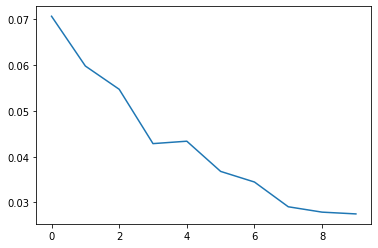

In [183]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])

In [202]:
from sklearn.metrics import accuracy_score
print("Test Accuracy:",accuracy_score(Y_test[:,1], np.round(results[:,1]))*100)

Test Accuracy: 60.324999999999996


LSTM Model

In [212]:
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))

model.add(LSTM(lstm_output_size))

model.add(Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 128)          2560000   
_________________________________________________________________
lstm_12 (LSTM)               (None, 70)                55720     
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 142       
Total params: 2,615,862
Trainable params: 2,615,862
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics = ['accuracy'])

In [214]:
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,shuffle=True, validation_data=(X_test, Y_test), verbose=2)

Train on 12000 samples, validate on 8000 samples
Epoch 1/10
 - 21s - loss: 0.5913 - acc: 0.7394 - val_loss: 0.5580 - val_acc: 0.7544
Epoch 2/10
 - 19s - loss: 0.5613 - acc: 0.7453 - val_loss: 0.5614 - val_acc: 0.7544
Epoch 3/10
 - 19s - loss: 0.5284 - acc: 0.7472 - val_loss: 0.6096 - val_acc: 0.7328
Epoch 4/10
 - 19s - loss: 0.4656 - acc: 0.7728 - val_loss: 0.6665 - val_acc: 0.6775
Epoch 5/10
 - 19s - loss: 0.4100 - acc: 0.8018 - val_loss: 0.7550 - val_acc: 0.6556
Epoch 6/10
 - 19s - loss: 0.3740 - acc: 0.8239 - val_loss: 0.7954 - val_acc: 0.6583
Epoch 7/10
 - 19s - loss: 0.3323 - acc: 0.8437 - val_loss: 0.9616 - val_acc: 0.6283
Epoch 8/10
 - 19s - loss: 0.3056 - acc: 0.8588 - val_loss: 0.9686 - val_acc: 0.5854
Epoch 9/10
 - 19s - loss: 0.2912 - acc: 0.8652 - val_loss: 1.1053 - val_acc: 0.6181
Epoch 10/10
 - 19s - loss: 0.2694 - acc: 0.8801 - val_loss: 1.1771 - val_acc: 0.6074


In [0]:
results = model.predict(X_test, verbose = 2, batch_size = batch_size)

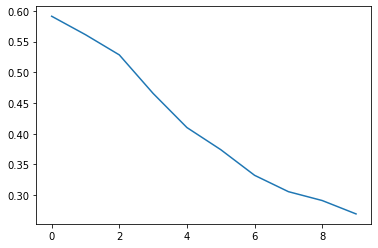

In [216]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])

In [217]:
from sklearn.metrics import accuracy_score
print("Test Accuracy:",accuracy_score(Y_test[:,1], np.round(results[:,1]))*100)

Test Accuracy: 70.8


Bi-LSTM Model

In [240]:
#creating model using Bi-directional LSTM
from keras import Sequential
from keras.layers import Embedding, Dense, LSTM, Bidirectional

#Hyperparameters used
max_features = 20000
maxlen = 100
embedding_size = 128
lstm_output_size = 70

Bi_LSTM_model = Sequential()

Bi_LSTM_model.add(Embedding(max_features, embedding_size, input_length=maxlen))

Bi_LSTM_model.add(Bidirectional(LSTM(lstm_output_size)))

Bi_LSTM_model.add(Dense(2, activation='sigmoid'))

Bi_LSTM_model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 100, 128)          2560000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 140)               111440    
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 282       
Total params: 2,671,722
Trainable params: 2,671,722
Non-trainable params: 0
_________________________________________________________________


In [0]:
Bi_LSTM_model.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics = ['accuracy'])


In [243]:
history = Bi_LSTM_model.fit(X_train, Y_train, batch_size=batch_size, epochs=4,shuffle=True, validation_data=(X_test, Y_test), verbose=2)

Train on 12000 samples, validate on 8000 samples
Epoch 1/4
 - 37s - loss: 0.5674 - acc: 0.7453 - val_loss: 0.5586 - val_acc: 0.7544
Epoch 2/4
 - 37s - loss: 0.5507 - acc: 0.7453 - val_loss: 0.5775 - val_acc: 0.7541
Epoch 3/4
 - 39s - loss: 0.4971 - acc: 0.7584 - val_loss: 0.6361 - val_acc: 0.7204
Epoch 4/4
 - 38s - loss: 0.4472 - acc: 0.7784 - val_loss: 0.6739 - val_acc: 0.6751


In [0]:
results = Bi_LSTM_model.predict(X_test, verbose = 2, batch_size = batch_size)

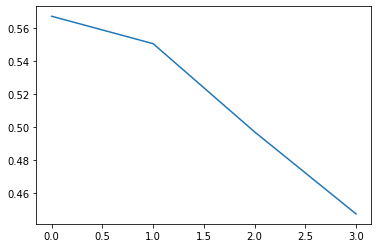

In [245]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])

In [246]:
from sklearn.metrics import accuracy_score
print("Test Accuracy:",accuracy_score(Y_test[:,1], np.round(results[:,1]))*100)

Test Accuracy: 74.9


Bi_LSTM_SoftMax

In [233]:
#creating model using Bi-directional LSTM and RELU
from keras import Sequential
from keras.layers import Embedding, Dense, LSTM, Bidirectional

#Hyperparameters used
max_features = 20000
maxlen = 100
embedding_size = 128
lstm_output_size = 70

Bi_LSTM_SoftMax_model = Sequential()

Bi_LSTM_SoftMax_model.add(Embedding(max_features, embedding_size, input_length=maxlen))

Bi_LSTM_SoftMax_model.add(Bidirectional(LSTM(lstm_output_size)))

Bi_LSTM_SoftMax_model.add(Dense(2, activation='relu'))

Bi_LSTM_SoftMax_model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 100, 128)          2560000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 140)               111440    
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 282       
Total params: 2,671,722
Trainable params: 2,671,722
Non-trainable params: 0
_________________________________________________________________


In [0]:
Bi_LSTM_SoftMax_model.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics = ['accuracy'])


In [236]:
history = Bi_LSTM_SoftMax_model.fit(X_train, Y_train, batch_size=batch_size, epochs=4,shuffle=True, validation_data=(X_test, Y_test), verbose=2)

Train on 12000 samples, validate on 8000 samples
Epoch 1/4
 - 38s - loss: 0.5656 - acc: 0.7453 - val_loss: 0.5604 - val_acc: 0.7544
Epoch 2/4
 - 37s - loss: 0.5420 - acc: 0.7455 - val_loss: 0.8600 - val_acc: 0.7544
Epoch 3/4
 - 37s - loss: 0.5148 - acc: 0.7535 - val_loss: 0.6981 - val_acc: 0.6953
Epoch 4/4
 - 37s - loss: 0.4714 - acc: 0.7693 - val_loss: 1.4155 - val_acc: 0.7147


In [0]:
results = Bi_LSTM_RELU_model.predict(X_test, verbose = 2, batch_size = batch_size)

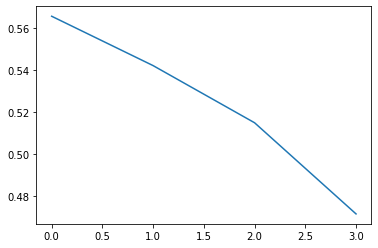

In [237]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])

In [247]:
from sklearn.metrics import accuracy_score
print("Test Accuracy:",accuracy_score(Y_test[:,1], np.round(results[:,1]))*100)

Test Accuracy: 74.9


Cross Validation using KFold and StratifiedKFold

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [0]:
#10-fold Cross Validation
from sklearn import model_selection
kf = model_selection.KFold(n_splits=10, shuffle=True)
total_accuracy = 0.0

In [0]:
#splitting the datasets into 10 folds - 9 for training and 1 for testing 
for train_index, test_index in kf.split(X):
	x_train, x_test = X[train_index], X[test_index]
	y_train, y_test = Y[train_index], Y[test_index]
	y_train_flat = np.argmax(y_train, axis=1)
	y_test_flat = np.argmax(y_test, axis=1)

In [198]:
#create model
model = Sequential()
model.add(Dense(2,activation='softmax'))
#Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# Fit the model
model.fit(x_train, y_train_flat, epochs=10, batch_size=256, verbose=0)

ValueError: ignored

In [201]:
model = LSTM()
model.fit(x_train, y_train_flat,batch_size=256,epochs=10)

TypeError: ignored

In [125]:
predictions = model.predict(x_test)
print (predictions)

[0 0 0 ... 0 0 0]


In [0]:
acc = metrics.accuracy_score(y_test_flat, predictions,batch_size=256)
total_accuracy += acc
#print (total_accuracy)

In [127]:
print(total_accuracy)

1.472


In [0]:
#Stratified K-fold
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits = 10)

In [0]:
#splitting the datasets into 10 folds Using StratifiedKFold - 9 for training and 1 for testing
for train_index, test_index in kf.split(X):
	x_train, x_test = X[train_index], X[test_index]
	y_train, y_test = Y[train_index], Y[test_index]
	y_train_flat = np.argmax(y_train, axis=1)
	y_test_flat = np.argmax(y_test, axis=1)

In [0]:
def get_score(model,x_train,x_test,y_train_flat,y_test_flat):
  model.fit(x_train,y_train_flat)
  return model.score(x_test,y_test_flat)

In [141]:
print(get_score(LogisticRegression(),x_train,x_test,y_train_flat,y_test_flat))
print(get_score(LSTM(),x_train,x_test,y_train_flat,y_test_flat))

0.741


TypeError: ignored